# Purpose of this simulation

we wanted to check that with full matrix works with lasso regression?

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import aopy
import sklearn
from weights import *
from weights_linear_regression import calc_R2_with_sim_C
from afs_plotting import subplots_with_labels

# so that we write in latex
from matplotlib import rc

# rc('font', **{'family':'serif','serif':['Palatino']})
rc('text', usetex=False)

import numpy as np
np.set_printoptions(precision=5, suppress=True)
sns.set_context('paper')
sns.set_theme("paper", font="Arial")

save_to_gdrive = False # this is done through the gdrive's mapping to the local file system
gdrive_directory = '/home/aolab/gdrive/Projects/Feature Selection/Figures/'
dpi_value = 300

/home/aolab/miniconda3/envs/sijia-feature-analysis/lib/python3.8/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/home/aolab/miniconda3/envs/sijia-feature-analysis/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:8: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/home/aolab/miniconda3/envs/sijia-feature-analysis/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:8: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


# ideas

In [2]:
data_dump_folder = \
        '/home/aolab/sijia/data/figure3_lasso/'

ROUND_DECIMALS = 3


random_seed =7
n_neurons = 128

# clda setup 
rho = 0.5
batchlen = 100
feature_selection_method = "joint_convex"
encoder_change_mode = "shuffle_rows"
# encoder_change_mode = "change_to_zeros"

# noises = np.arange(9)
# noises = np.exp2(noises)
noises = [32]
noise = 32

# we set up the neural populations
mean_first_peak = 50
mean_second_peak = 100
std_of_peaks = 3

# feature_selection_method 
feature_selection_method = "full"
exp_conds = []

# uncomment out this to compare to the full feature selection method
# exp_conds_wo = [f'{feature_selection_method}_{1.0}_{random_seed}_noise_{noise}_{n_neurons}_{mean_second_peak}_{std_of_peaks}_clda_rho_{rho}_batchlen_{batchlen}_{encoder_change_mode}' ]
# exp_conds += exp_conds_wo




#smoothness_array =  np.arange(0.025, 0.15, 0.025)
smoothness_array = [0.05]
num_lags_array = [3]
num_of_features = 32 # specify how many features we want to use, or None

encoder_change_modes = ["same", "shuffle_rows"]

##### lasso
lasso_alphas = [10]
lasso_thresholds = [1]
for encoder_change_mode in encoder_change_modes:
    more_exp_conds = []
    for lasso_alpha in lasso_alphas:
        for lasso_threshold in lasso_thresholds:
            more_exp_conds.append(f'lasso_{1.0}_{random_seed}_noise_{noise}_{n_neurons}_{mean_second_peak}_{std_of_peaks}_clda_rho_{rho}_batchlen_{batchlen}_lasso_alpha_{lasso_alpha}_lasso_threshold_{lasso_threshold}_{encoder_change_mode}')
    exp_conds += more_exp_conds

    ##### last one is with the full feature selection
    more_exp_conds = []
    updater_type = "smooth_batch_with_full_feature"
    for lasso_alpha in lasso_alphas:
        for lasso_threshold in lasso_thresholds:
            more_exp_conds.append(f'lasso_{1.0}_{random_seed}_noise_{noise}_{n_neurons}_{mean_second_peak}_{std_of_peaks}_clda_rho_{rho}_batchlen_{batchlen}_lasso_alpha_{lasso_alpha}_lasso_threshold_{lasso_threshold}_{encoder_change_mode}')

    # add smooth batch with full batch
    UPDATER_TYPE = "smooth_batch_with_full_feature"
    if  UPDATER_TYPE != 'smooth_batch':
        for i, exp_cond in enumerate(more_exp_conds):
            more_exp_conds[i] = exp_cond + f'_{UPDATER_TYPE}'

    exp_conds += more_exp_conds

# feature_selection_schemes = ['lasso threshold 0','lasso threshold 1', 'lasso threshold 2', 'lasso threshold 2.5',
#                              'lasso threshold 0 w/ full matrix','lasso w/ full matrix threshold 1', 'lasso w/ full matrix threshold 2', 'lasso w/ full matrix threshold 2.5']

feature_selection_schemes = ['w/o tracking ',
                             'w/ tracking ',
                             'w/o tracking',
                             'w/ tracking',]


print("the folder at which data is located:")
print(data_dump_folder)
for m,e in zip(feature_selection_schemes, exp_conds):print(m, ':', e)

the folder at which data is located:
/home/aolab/sijia/data/figure3_lasso/
w/o tracking  : lasso_1.0_7_noise_32_128_100_3_clda_rho_0.5_batchlen_100_lasso_alpha_10_lasso_threshold_1_same
w/ tracking  : lasso_1.0_7_noise_32_128_100_3_clda_rho_0.5_batchlen_100_lasso_alpha_10_lasso_threshold_1_same_smooth_batch_with_full_feature
w/o tracking : lasso_1.0_7_noise_32_128_100_3_clda_rho_0.5_batchlen_100_lasso_alpha_10_lasso_threshold_1_shuffle_rows
w/ tracking : lasso_1.0_7_noise_32_128_100_3_clda_rho_0.5_batchlen_100_lasso_alpha_10_lasso_threshold_1_shuffle_rows_smooth_batch_with_full_feature


In [3]:
from afs_files import load_feature_selection_files, load_and_convert_clda_pickle_files
(exp_data_all, exp_metadata_all) = load_feature_selection_files(data_dump_folder, exp_conds)
clda_data_all = load_and_convert_clda_pickle_files(data_dump_folder, exp_conds)
print(f'we collected {len(exp_data_all)} number of experiments')

/home/aolab/sijia/analyze/aopy/preproc/bmi3d.py:382: UserWarning: Warning: no sync clock connected! This will usually result in problems.
  warnings.warn("Warning: no sync clock connected! This will usually result in problems.")
/home/aolab/sijia/analyze/aopy/preproc/bmi3d.py:449: UserWarning: No sync events present, using bmi3d events instead
  warnings.warn("No sync events present, using bmi3d events instead")


we collected 4 number of experiments


# Check feature selection strategies

## Plot selected features across feature selection methods

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

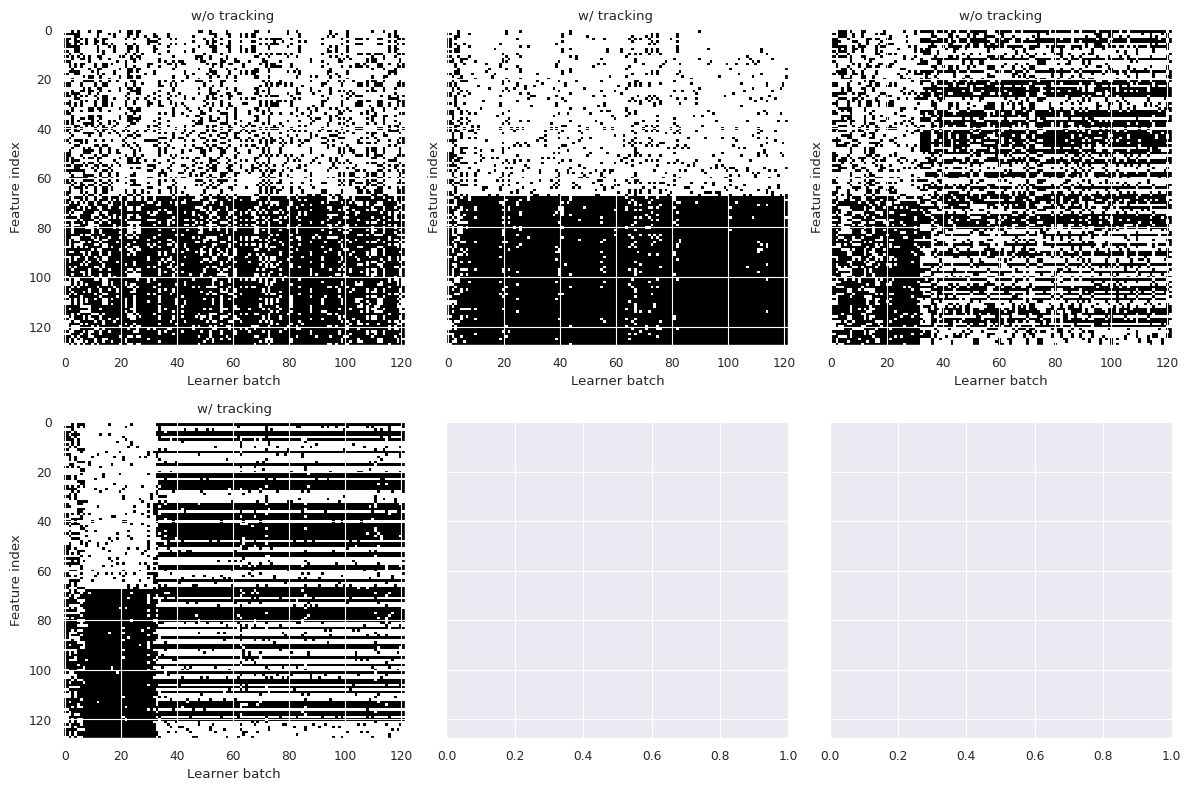

In [4]:
import importlib 
from afs_plotting import plot_feature_selection

if len(exp_data_all) ==  1:
    plot_feature_selection(exp_data_all[0]['feature_selection']['feat_set'])
else:
    
    num_columns = len(exp_data_all)

    fig_feat_activity, ax_feat_activity = plt.subplots(2, 3, 
                                                    sharey = True,
                                                    figsize = (12, 8))

    for i, (e, a) in enumerate(zip(exp_data_all,  ax_feat_activity.flatten())):
        plot_feature_selection(e['feature_selection']['feat_set'], ax = a)
        
        a.set_title(feature_selection_schemes[i])

fig_feat_activity.tight_layout()



## plot the encoder change

In [5]:
def calculate_encoder_weight_change(sim_c, new_sim_c=None,
                                     include_new_sim_c=False, nnum_of_repeats_before=30, num_of_repeats_after=30):
    good_features_initial = (np.linalg.norm(sim_c, axis=1))
    if include_new_sim_c:
        good_features_after_shuffled = (np.linalg.norm(new_sim_c, axis=1))
    else:
        good_features_after_shuffled = good_features_initial

    old_features_before_shuffled_repeat = np.repeat(good_features_initial[:, np.newaxis],
                                                    nnum_of_repeats_before, axis = 1)
    new_features_after_shuffled_repeat = np.repeat(good_features_after_shuffled[:, np.newaxis],
                                                    num_of_repeats_after, axis = 1)

    encoder_weight_change = np.concatenate((old_features_before_shuffled_repeat,
                                            new_features_after_shuffled_repeat), axis = 1)
    return encoder_weight_change

In [23]:

new_sim_c = exp_data_all[0]['feature_selection']['new_sim_c']
sim_c = exp_data_all[0]['feature_selection']['sim_C']
encoder_weight_change_stationary = calculate_encoder_weight_change(sim_c,
                                        include_new_sim_c=False, nnum_of_repeats_before=30, num_of_repeats_after=90)

new_sim_c = exp_data_all[2]['feature_selection']['new_sim_c']
sim_c = exp_data_all[2]['feature_selection']['sim_C']
encoder_weight_change_shuffle = calculate_encoder_weight_change(sim_c, new_sim_c=new_sim_c,
                                        include_new_sim_c=True, nnum_of_repeats_before=30, num_of_repeats_after=90)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


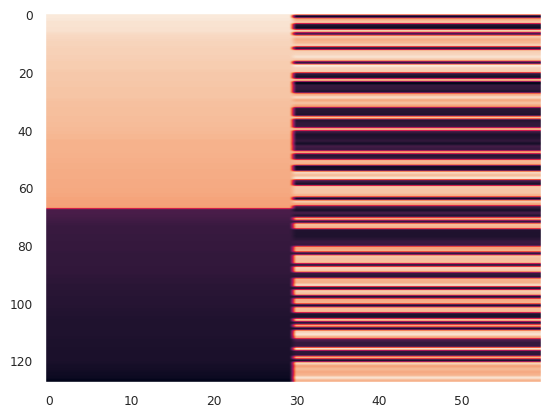

In [7]:
plt.imshow(encoder_weight_change_shuffle, aspect = 'auto')
plt.grid(False)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

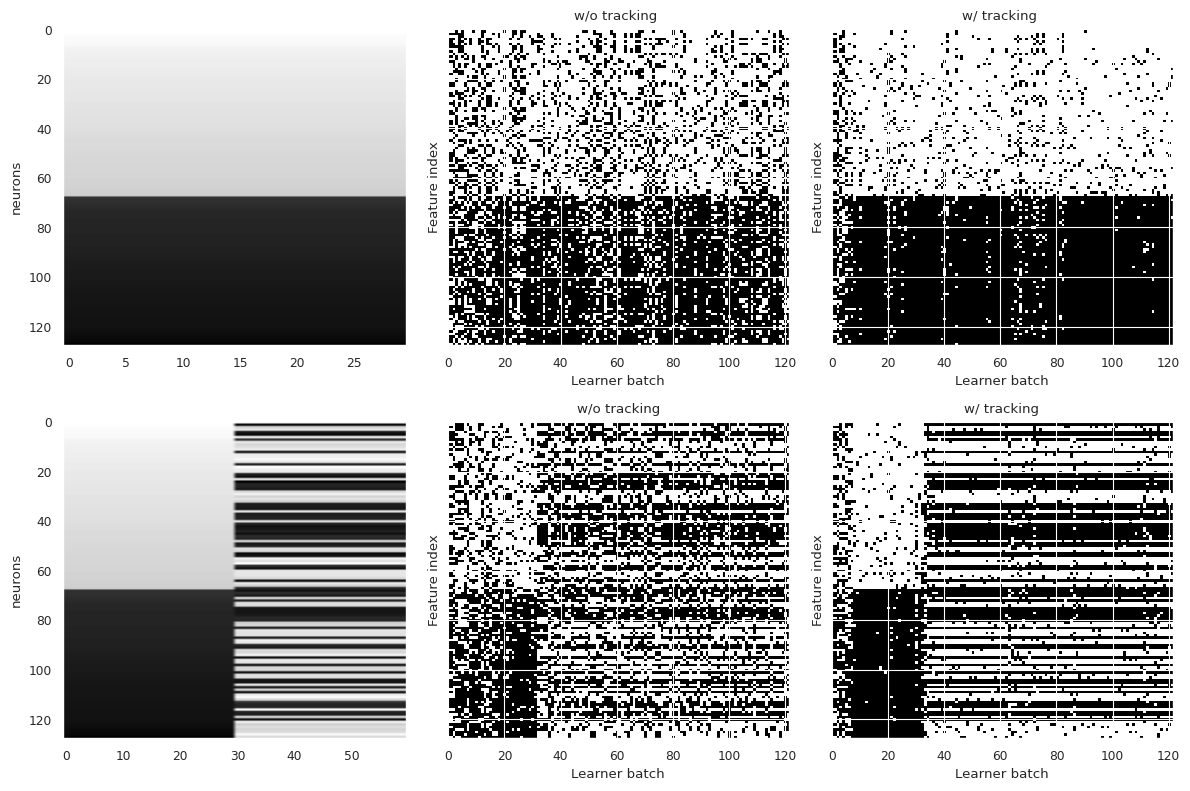

In [8]:
if len(exp_data_all) ==  1:
    plot_feature_selection(exp_data_all[0]['feature_selection']['feat_set'])
else:
    
    num_columns = len(exp_data_all)

    fig_feat_activity, ax_encoder_feat_activity = plt.subplots(2, 3, 
                                                    sharey = True,
                                                    figsize = (12, 8))
    
    ax_encoder_feat_activity[0, 0].imshow(encoder_weight_change_stationary, cmap = 'gray',
                                          aspect = 'auto')
    ax_encoder_feat_activity[0, 0].grid(False)
    ax_encoder_feat_activity[0, 0].set_ylabel('neurons')

    ax_encoder_feat_activity[1, 0].imshow(encoder_weight_change_shuffle, cmap = 'gray',
                                          aspect = 'auto')
    ax_encoder_feat_activity[1, 0].grid(False)
    ax_encoder_feat_activity[1, 0].set_ylabel('neurons')
    
    ax_feat_activity = ax_encoder_feat_activity[:, 1:]

    for i, (e, a) in enumerate(zip(exp_data_all,  ax_feat_activity.flatten())):
        plot_feature_selection(e['feature_selection']['feat_set'], ax = a)
        
        a.set_title(feature_selection_schemes[i])

fig_feat_activity.tight_layout()

## plot the number of features

In [9]:
# next question I ask,  how many features are being selected, anyway? 
num_features_exp_by_batch = []

selected_feature_batches = [exp_data_all[i]['feature_selection']['feat_set'] for i in range(len(exp_data_all))]

for i,e in enumerate(exp_data_all):

    active_set = e['feature_selection']['feat_set']

    num_features_over_batch = np.sum(active_set, axis = 1)
    num_features_exp_by_batch.append(num_features_over_batch.copy())

num_features_exp_by_batch = np.array(num_features_exp_by_batch)
selected_feature_batches = np.array(selected_feature_batches)


In [10]:
print(selected_feature_batches.shape)

selected_features_conds_by_feature_batches = np.moveaxis(selected_feature_batches, 1, 2)


smoothness_conds_by_batch = \
calculate_feature_smoothness_multiple_conditions(selected_features_conds_by_feature_batches, 
                                                 mode = "incremental")

print(smoothness_conds_by_batch.shape)

(4, 122, 128)
(4, 121)


(4, 121)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

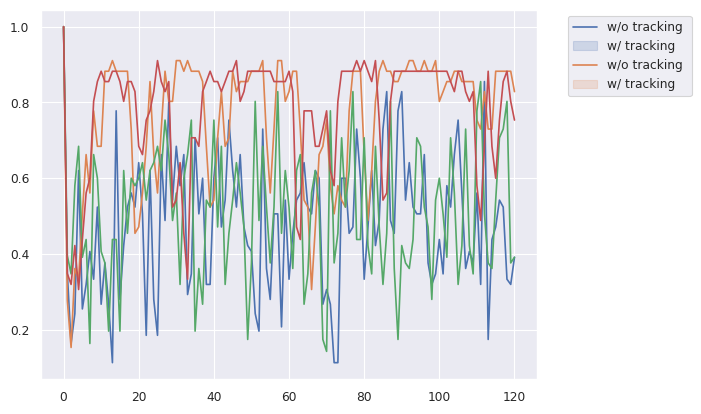

In [11]:
#sns.set_palette("Blues")

ax  = sns.lineplot(data = smoothness_conds_by_batch.T, dashes=False)
# ax.set_xticklabels(sparsity_array)
ax.set_title("")

# put legend outside of the plot

ax.legend(feature_selection_schemes, bbox_to_anchor=(1.05, 1), loc=2)
smoothness_conds_by_batch.shape

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

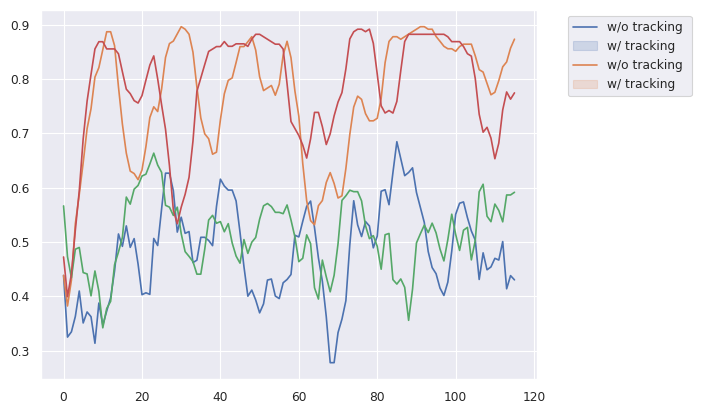

In [12]:

# Assuming smoothness_conds_by_batch is a numpy array with shape (n_batches, n_features)
window_size = 6
weights = np.ones(window_size) / window_size
smoothness_conds_by_batch_ma = np.apply_along_axis(lambda x: np.convolve(x, weights, mode='valid'), 
                                                   axis=1,
                                                   arr=smoothness_conds_by_batch)

ax  = sns.lineplot(data = smoothness_conds_by_batch_ma.T, dashes=False)
# ax.set_xticklabels(sparsity_array)
ax.set_title("")

# put legend outside of the plot

ax.legend(feature_selection_schemes, bbox_to_anchor=(1.05, 1), loc=2)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

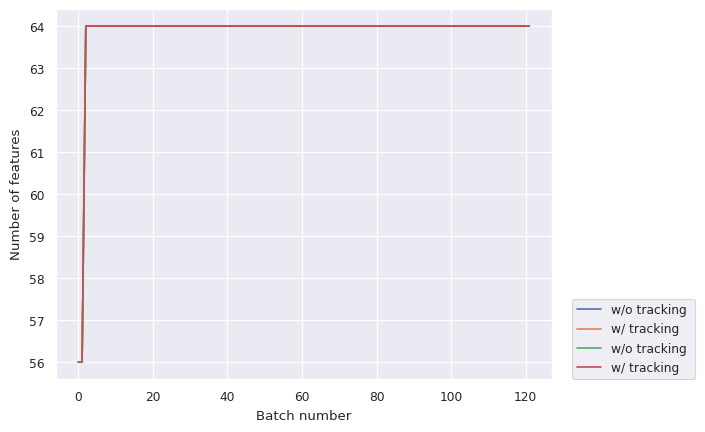

In [13]:
fig_num_features, ax_num_features = plt.subplots()

ax_num_features.plot(num_features_exp_by_batch.T)

ax_num_features.set_xlabel('Batch number')
ax_num_features.set_ylabel('Number of features')

ax_num_features.legend(feature_selection_schemes, loc=(1.04,0))

## calculate the relevance


In [14]:
from sklearn.metrics import r2_score

def calc_R2_with_sim_C( spike_counts_batch,intended_velocities, C_mat, active_set, 
                       remove_first_and_last_Batch = True, 
                       c_mat_remove_first_batch = True, 
                       select_only_vel_states = True,
                       select_features_with_active_set = False,
                       debug = True):
    
    
        # then we iterate through the batch sort of thing.
    NUM_LEARNER_BATCHES = intended_velocities.shape[0]
    
    if debug:
        print("intended_velocities", intended_velocities.shape)
        print("spike_counts_batch", len(spike_counts_batch))
        print("C_mat", C_mat.shape)
        print("active_set", active_set.shape)
    
    if remove_first_and_last_Batch:
        active_set = active_set[1:-1, :]
    if c_mat_remove_first_batch:
        C_mat = C_mat[1:, :, : ]
        
    if select_only_vel_states:
        C_mat = C_mat[:,:,(X_VEL_STATE, Y_VEL_STATE,CONST_STATE)]
        
    
    if debug:
        print("intended_velocities", intended_velocities.shape)
        print("spike_counts_batch", len(spike_counts_batch))
        print("C_mat", C_mat.shape)
        print("active_set", active_set.shape)
        

    
    R_2_over_batch = []
    
    for i in range(NUM_LEARNER_BATCHES):
        
        batch_vel =  intended_velocities[i,:,:]
        
        # check if we get the data from the list or the np.ndarray
        if type(spike_counts_batch) == list:
            batch_spike_counts = spike_counts_batch[i]
        else:
            batch_spike_counts = spike_counts_batch[i,:,:]
        
        #  we can only compare to what's being used in the calculation
        if select_features_with_active_set:
            if debug: print(batch_spike_counts.shape)
            batch_spike_counts = batch_spike_counts[active_set[i,:],:].T
        else:
            batch_spike_counts = batch_spike_counts[: ,:].T
        
        batch_c_mat = C_mat[i,:,:]
        
        selected_c_mat = batch_c_mat[active_set[i,:],:]
        

        estimated_spike_counts = selected_c_mat @ batch_vel
        
        score = r2_score(batch_spike_counts, estimated_spike_counts.T)
        
        R_2_over_batch.append(score)
        
    return R_2_over_batch

In [15]:

R_2_over_batches_all_exp = []


X_VEL_STATE = 3
Y_VEL_STATE = 5
CONST_STATE = 6

for exp_index in range(len(exp_data_all)):
    # intended_kin = exp_data_all[exp_index]['bmi3d_clda']['intended_kin']
    # spike_counts_batch = exp_data_all[exp_index]['bmi3d_clda']['spike_counts_batch']
    
    try:
        intended_kin = clda_data_all[exp_index]['intended_kin']
        spike_counts_batch = clda_data_all[exp_index]['spike_counts_batch']

        intended_kin = np.array(intended_kin)
        print(intended_kin.shape)

        intended_velocities = intended_kin[:, [X_VEL_STATE, Y_VEL_STATE, CONST_STATE],:]
        # # get C_mat
        feature_selection_data = exp_data_all[exp_index]['feature_selection']
        C_mat = feature_selection_data["C_mat"]
        feat_set = feature_selection_data["feat_set"]

        # # calculate R_2 over batches
        R_2_over_batches = calc_R2_with_sim_C(spike_counts_batch, 
                                            intended_velocities,
                                            C_mat, feat_set, debug = False)
        
        # #save  the results
        R_2_over_batches_all_exp.append(R_2_over_batches)
        
        
    except Exception as e:
        print(f"KeyError: {e}not found in data.")
    
    # #save  the results
    # R_2_over_batches_all_exp.append(R_2_over_batches)
    
    print(exp_index)
    
R_2_over_batches_all_exp = np.array(R_2_over_batches_all_exp)
R_2_over_batches_all_exp_gap = R_2_over_batches_all_exp.T

(120, 7, 100)
0
(120, 7, 100)
1
(120, 7, 100)
2
(120, 7, 100)
3


In [16]:
# apply moving average to the first axis
window_size = 6
weights = np.ones(window_size) / window_size
R_2_over_batches_all_exp_gap_ma = np.apply_along_axis(lambda x: np.convolve(x, weights, mode='valid'), 
                                                   axis=0,
                                                   arr=R_2_over_batches_all_exp_gap)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

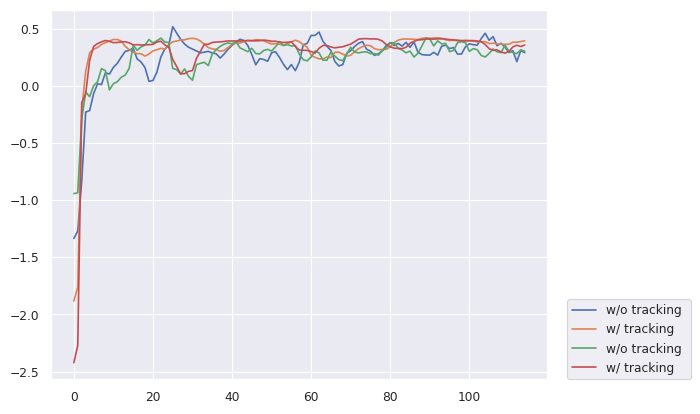

In [17]:
plt.plot(R_2_over_batches_all_exp_gap_ma)
plt.legend(feature_selection_schemes, loc=(1.04,0))



# Behaviour comparision

## count how many rewards

In [18]:
fps = 60

reward_rate_all = list()
window_time_stamps_all = list()
NUM_EXP = len(exp_data_all)

total_rewards_all = list()

for i in range(NUM_EXP):

    time_stamps = exp_data_all[i]['events']['time'] / fps
    events = exp_data_all[i]['events']['event']
    
    
    num_rewards = np.count_nonzero(events == b'REWARD')

    (reward_rate, window_time_stamps) = aopy.analysis.calc_running_event_rate(b'REWARD', events, time_stamps, 
                                                                window_size= 120,
                                                                 window_step= 30)
    reward_rate_all.append(reward_rate)
    window_time_stamps_all.append(window_time_stamps)
    total_rewards_all.append(num_rewards)


window_stamps_all = np.array(window_time_stamps_all)
reward_rate_all = np.array(reward_rate_all) 
reward_rate_all = reward_rate_all.reshape((NUM_EXP,-1))
window_stamps_all = window_stamps_all.reshape((NUM_EXP,-1))

total_rewards_all = np.array(total_rewards_all)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

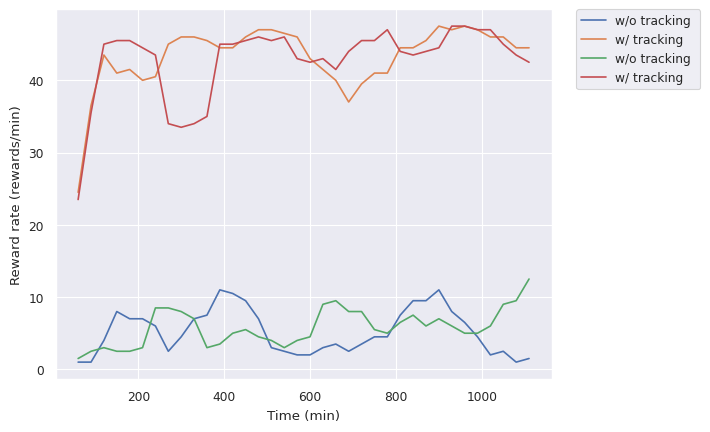

In [19]:
colors = ['blue', 'orange', 'red']

plt.plot(window_time_stamps, reward_rate_all.T)
plt.xlabel('Time (min)')
plt.ylabel(r'Reward rate (rewards/min)')
# put the legend outside of the figure
plt.legend(feature_selection_schemes, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


## PLOT: summary plot

/tmp/ipykernel_2415049/1125309993.py:72: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  summary_figure.subplots_adjust(bottom=0.2)
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not

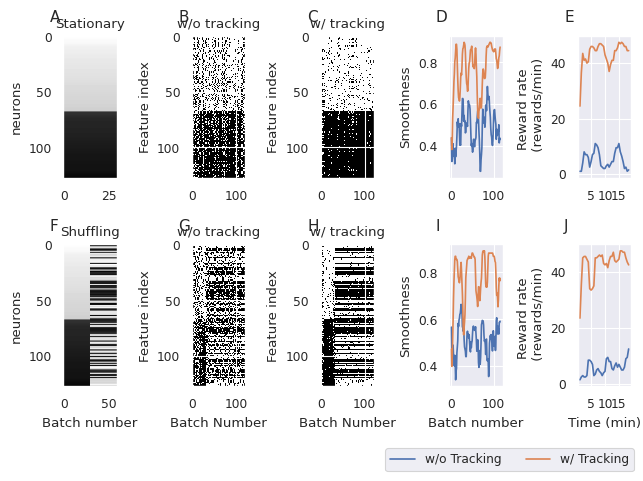

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

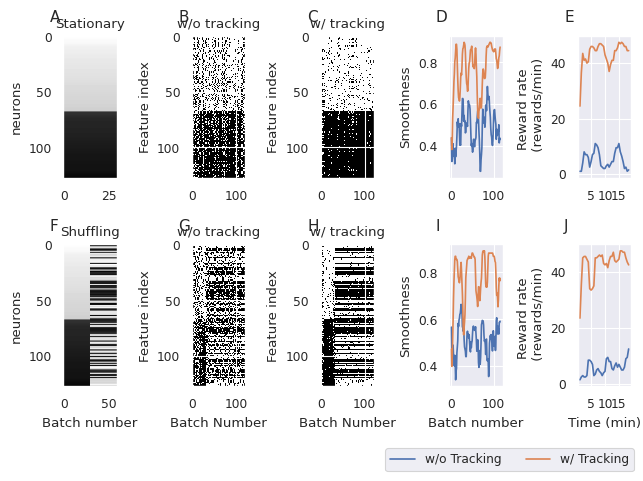

In [20]:
# make the figure according to the plan
summary_figure, summary_axes = subplots_with_labels(2, 5,
                                            figsize = (6.5, 4.5 ))

# specify the line styles
line_styles = ['--', '-', '--', '-']
line_colors = ['blue', 'blue', 'orange', 'orange']
legends = ['w/o Tracking', 'w/ Tracking']

stationary_shuffling_indices = [[0,1], [2,3]]

# top left, is the ground truth for the staionary encoder
# we don't have that yet
summary_axes[0,0].imshow(encoder_weight_change_stationary, cmap = 'gray',
                                            aspect = 'auto')
summary_axes[0,0].grid(False)
summary_axes[0,0].set_ylabel('neurons')
summary_axes[0,0].set_title('Stationary')

# then the shuffling encoder case
summary_axes[1,0].imshow(encoder_weight_change_shuffle, cmap = 'gray',
                                          aspect = 'auto')
summary_axes[1,0].grid(False)
summary_axes[1,0].set_ylabel('neurons')
summary_axes[1,0].set_title('Shuffling')
summary_axes[1,0].set_xlabel('Batch number')


# top middle and right is the strategy for the stationary encoder

plot_feature_selection(exp_data_all[0]['feature_selection']['feat_set'], ax = summary_axes[0,1])
plot_feature_selection(exp_data_all[1]['feature_selection']['feat_set'], ax = summary_axes[0,2])
summary_axes[0,1].set_xlabel('')
summary_axes[0,2].set_xlabel('')

summary_axes[0,1].set_title(feature_selection_schemes[2])
summary_axes[0,2].set_title(feature_selection_schemes[3])

# middle middle and right is the strategy for the shuffle encoder
plot_feature_selection(exp_data_all[2]['feature_selection']['feat_set'], ax = summary_axes[1,1])
plot_feature_selection(exp_data_all[3]['feature_selection']['feat_set'], ax = summary_axes[1,2])
summary_axes[1,1].set_title(feature_selection_schemes[2])
summary_axes[1,2].set_title(feature_selection_schemes[3])
summary_axes[1,1].set_xlabel('Batch Number')
summary_axes[1,2].set_xlabel('Batch Number')


# two right figures are smoothness and reward rate comparisions
summary_axes[0,3].plot(smoothness_conds_by_batch_ma[stationary_shuffling_indices[0], :].T, 
                       label = legends)
summary_axes[1,3].plot(smoothness_conds_by_batch_ma[stationary_shuffling_indices[1],:].T)

summary_axes[1,3].set_xlabel('Batch number')
summary_axes[0,3].set_ylabel('Smoothness')
summary_axes[1,3].set_ylabel('Smoothness')


# then the reward rate
summary_axes[0,4].plot(window_time_stamps / 60, 
                       reward_rate_all[stationary_shuffling_indices[0],:].T)

summary_axes[1,4].plot(window_time_stamps / 60,
                          reward_rate_all[stationary_shuffling_indices[1],:].T)
summary_axes[1,4].set_xlabel('Time (min)')
summary_axes[0,4].set_ylabel('Reward rate \n (rewards/min)')
summary_axes[1,4].set_ylabel('Reward rate \n (rewards/min)')


# put the legend outside of the figure
lgd = summary_figure.legend(bbox_to_anchor=(0.6, -.01), ncol = 2, 
                         loc=2, borderaxespad=0.)
summary_figure.subplots_adjust(bottom=0.2)

summary_figure.tight_layout()
summary_figure

### we transform into the new format of two columns for stationary and shuffling encoder, respectively

In [24]:
from afs_plotting import concatenate_encoder_weights_feature_sets

# concatennate encoder weights and feature sets work for the first and last exp_data_all
encoder_weights_features_sets_stationary = concatenate_encoder_weights_feature_sets(
    encoder_weight_change_stationary, exp_data_all[:2]
)

encoder_weights_features_sets_shuffle = concatenate_encoder_weights_feature_sets(
    encoder_weight_change_shuffle, exp_data_all[2:]
)

print(encoder_weights_features_sets_stationary.shape)
print(encoder_weights_features_sets_shuffle.shape)

(128, 374)
(128, 374)


## PLOT the new column format

/tmp/ipykernel_2415049/3530051332.py:70: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  summary_figure.subplots_adjust(bottom=0.2)
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not

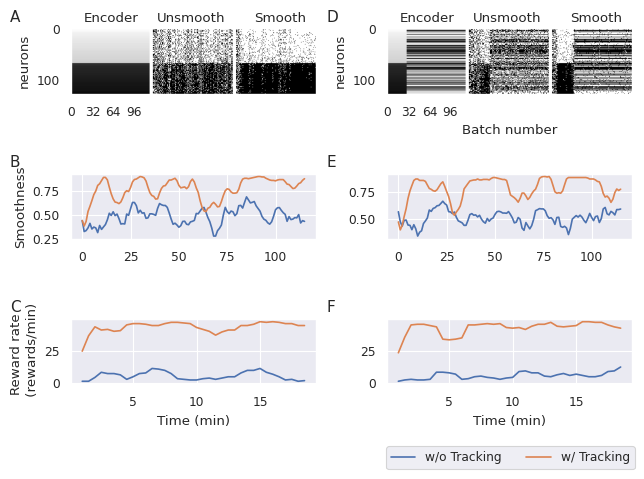

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

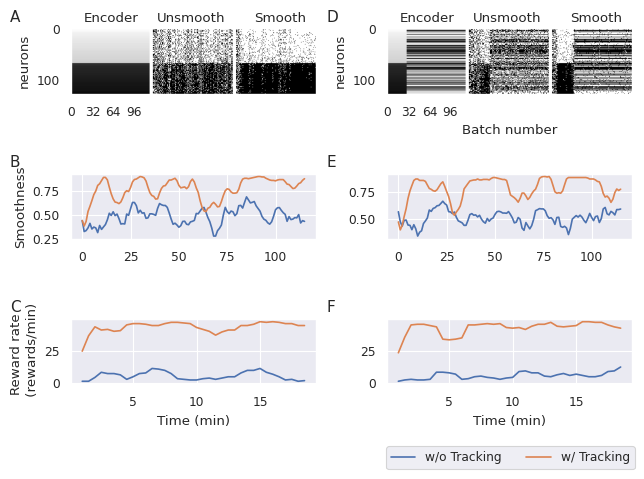

In [42]:
num_batches = encoder_weight_change_stationary.shape[0]
delta_batch_for_display = 32

# make the figure according to the plan
summary_figure, summary_axes = subplots_with_labels(3, 2,
                                            figsize = (6.5, 4.5 ),
                                            label_directions='col_first')

# specify the line styles
line_styles = ['--', '-', '--', '-']
line_colors = ['blue', 'blue', 'orange', 'orange']
legends = ['w/o Tracking', 'w/ Tracking']

stationary_shuffling_indices = [[0,1], [2,3]]

# top left, is the ground truth for the staionary encoder
# we don't have that yet
summary_axes[0,0].imshow(encoder_weights_features_sets_stationary, cmap = 'gray',
                                            aspect = 'auto')
summary_axes[0,0].grid(False)
summary_axes[0,0].set_ylabel('neurons')

summary_axes[0,0].set_xticks(np.arange(0, num_batches, delta_batch_for_display))
summary_axes[0,0].set_xticklabels(np.arange(0, num_batches, delta_batch_for_display ))

# put three texts  encoder, smooth, unsmooth on top of the first row, evenly spaced
ax_feat_activity = summary_axes[0,0]
ax_feat_activity.text(0.05, 1.1, 'Encoder', transform=ax_feat_activity.transAxes)
ax_feat_activity.text(0.35, 1.1, 'Unsmooth', transform=ax_feat_activity.transAxes)
ax_feat_activity.text(0.75, 1.1, 'Smooth', transform=ax_feat_activity.transAxes)


# then the shuffling encoder case
summary_axes[0,1].imshow(encoder_weights_features_sets_shuffle, cmap = 'gray',
                                          aspect = 'auto')
summary_axes[0,1].grid(False)
summary_axes[0,1].set_ylabel('neurons')
summary_axes[0,1].set_xlabel('Batch number')
summary_axes[0,1].set_xticks(np.arange(0, num_batches, delta_batch_for_display))
summary_axes[0,1].set_xticklabels(np.arange(0, num_batches, delta_batch_for_display ))

# put three texts  encoder, smooth, unsmooth on top of the first row, evenly spaced
ax_feat_activity = summary_axes[0,1]
ax_feat_activity.text(0.05, 1.1, 'Encoder', transform=ax_feat_activity.transAxes)
ax_feat_activity.text(0.35, 1.1, 'Unsmooth', transform=ax_feat_activity.transAxes)
ax_feat_activity.text(0.75, 1.1, 'Smooth', transform=ax_feat_activity.transAxes)

# two right figures are smoothness and reward rate comparisions
summary_axes[1,0].plot(smoothness_conds_by_batch_ma[stationary_shuffling_indices[0], :].T, 
                       label = legends)
summary_axes[1,1].plot(smoothness_conds_by_batch_ma[stationary_shuffling_indices[1],:].T)

summary_axes[1,0].set_ylabel('Smoothness')


# then the reward rate
summary_axes[2,0].plot(window_time_stamps / 60, 
                       reward_rate_all[stationary_shuffling_indices[0],:].T)

summary_axes[2,1].plot(window_time_stamps / 60,
                          reward_rate_all[stationary_shuffling_indices[1],:].T)
summary_axes[2,0].set_xlabel('Time (min)')
summary_axes[2,1].set_xlabel('Time (min)')
summary_axes[2,0].set_ylabel('Reward rate \n (rewards/min)')
summary_axes[2,1].set_xlabel('Time (min)')

# put the legend outside of the figure
lgd = summary_figure.legend(bbox_to_anchor=(0.6, -.01), ncol = 2, 
                         loc=2, borderaxespad=0.)
summary_figure.subplots_adjust(bottom=0.2)

summary_figure.tight_layout()
summary_figure

## save to gdrive

In [43]:
if gdrive_directory:
    summary_figure.savefig(gdrive_directory + 'figure3_lasso_encoder_change.pdf', dpi = dpi_value,
                            bbox_extra_artists=(lgd,), bbox_inches='tight')
    summary_figure.savefig(gdrive_directory + 'figure3_lasso_encoder_change.png', 
                           bbox_extra_artists=(lgd,),dpi = dpi_value, bbox_inches='tight')

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f